# EDA (Exploratory Data Analysis)

## Import Library

In [20]:
import pandas as pd
import glob
from pathlib import Path
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

BASE_DIR = Path("D:\\AUNUUN JEFFRY MAHBUUBI\\PROJECT AND RESEARCH\\PROJECTS\\36. FNIRS-Anxiety\\CODE\\3. fNIRS\\data\\raw")

## Data Structure

In [21]:
def organize_data(directory):
    # Find all CSV files in the directory
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    excel_files = glob.glob(os.path.join(directory, "*.xlsx"))

    # Load the Excel file
    df_excel = pd.read_excel(excel_files[0])

    # Extract subject IDs, tasks, and records from the Excel file
    subject_ids = df_excel.iloc[:, 0]
    tasks = df_excel.iloc[:, 1]
    records = df_excel.iloc[:, -1]

    # Dictionary to store subject data
    subject_data = {}

    for idx, subject_id in enumerate(subject_ids):
        task = tasks[idx]
        record = records[idx]

        # Create or update the subject entry
        if subject_id not in subject_data:
            # Classify based on the second character of the subject ID
            classification = 'healthy' if subject_id[1] == 'H' else 'non-healthy'
            subject_data[subject_id] = {'data': {}, 'class': classification}

        # Collect all files (HbO, HbR, HbT) that match the record
        matched_files = []
        for csv_file in csv_files:
            filename = "_".join(os.path.basename(csv_file).split("_")[:2])
            if record == filename:
                matched_files.append(csv_file)

        # If we find all three (HbO, HbR, HbT) for the task, store them in a list under the task
        if matched_files:
            subject_data[subject_id]['data'][task] = matched_files

    return pd.DataFrame.from_dict(subject_data, orient='index')


def load_task_data(task_dict):
    all_task_data = {}

    for task_name, task_files in task_dict.items():
        data_frames = {}
        # print(f"Loading data for task: {task_name}")
        # Load each file (HbO, HbR, HbT) for the given task
        for file_path in task_files:
            filename_with_extension = file_path.split("\\")[-1]
            filename = filename_with_extension.split(".csv")[0]

            data_type = file_path.split('_')[-1].split('.')[0]  # Extract 'HbO', 'HbR', or 'HbT' from filename
            df = pd.read_csv(file_path, header=None)

            # Include filename in the dictionary alongside the dataframe
            data_frames[data_type] = {
                'filename': filename,  # Store filename
                'data': df              # Store the dataframe
            }

        # Store the data for this task
        all_task_data[task_name] = data_frames

    return all_task_data

def plot_hbo_hbr_hbt(hbo, hbr, hbt):
    time = hbo.iloc[0, :]
    channels_HbO = hbo.iloc[2:, :]
    channels_HbR = hbr.iloc[2:, :]
    channels_HbT = hbt.iloc[2:, :]

    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    # Plot HbO
    axs[0].plot(time, channels_HbO.T)
    axs[0].set_title('HbO')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('HbO Signal')

    # Plot HbR
    axs[1].plot(time, channels_HbR.T)
    axs[1].set_title('HbR')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('HbR Signal')

    # Plot HbT
    axs[2].plot(time, channels_HbT.T)
    axs[2].set_title('HbT')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('HbT Signal')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

def plot_fnirs_data(time, channels, marker, time_baseline_start, time_task_end, extracted_time, extracted_data):
    """
    Plots three subplots:
    1. Original data without any extraction.
    2. Original data with markers and highlighted extraction range.
    3. Extracted data.

    Args:
    - time (array): Array of time points.
    - channels (array): 2D array of fNIRS channel data.
    - marker (array): Array of markers indicating task/baseline.
    - time_baseline_start (float): Start time of the baseline period.
    - time_task_end (float): End time of the task period.
    - extracted_time (array): Time points for the extracted data.
    - extracted_data (array): Extracted fNIRS data corresponding to the time period.
    """
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # 1. Plot original data
    axs[0].plot(time, channels.T, alpha=0.6)
    axs[0].set_title('Original Data')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Channel Signals')

    # 2. Plot original data with markers and highlighted path for extraction
    axs[1].plot(time, channels.T, alpha=0.6)
    time_markers_1 = time[marker == 1]
    time_markers_3 = time[marker == 3]
    for t in time_markers_1:
        axs[1].axvline(x=t, color='green', linestyle='--', label='Marker 1')
    for t in time_markers_3:
        axs[1].axvline(x=t, color='red', linestyle='--', label='Marker 3')
    axs[1].axvspan(time_baseline_start, time_task_end, color='yellow', alpha=0.3, label='Extraction Range')
    
    # Create legend patches
    red_patch = mpatches.Patch(color='red', label='Marker 3 (Task)')
    green_patch = mpatches.Patch(color='green', label='Marker 1 (Baseline)')
    yellow_patch = mpatches.Patch(color='yellow', alpha=0.3, label='Extraction Range')
    axs[1].legend(handles=[green_patch, red_patch, yellow_patch])
    axs[1].set_title('Original Data with Markers and Highlighted Extraction Range')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Channel Signals')

    # 3. Plot extracted data
    axs[2].plot(extracted_time, extracted_data.T, alpha=0.6)
    axs[2].set_title('Extracted Data')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Channel Signals')

    plt.tight_layout()
    plt.show()

def calculate_sampling_frequency(df, task):
    """
    Function to calculate the sampling frequency for each subject based on the provided task.
    Optionally adds 'class' attribute if check_class is True.

    Args:
    - df (DataFrame): DataFrame containing subject information.
    - task (str): Task name to check ('VF', '1backWM', 'SS', 'GNG').
    - check_class (bool): If True, includes the 'class' attribute in the result.

    Returns:
    - List of dictionaries containing the subject index, sampling frequency, and optionally 'class'.
    """
    # Create an empty list to store sampling frequencies for each subject
    sampling_frequencies = []

    # Loop through each subject in the dataframe
    for index, row in df.iterrows():
        # Load task data for the subject
        subject_data = load_task_data(row['data'])
        class_label = row['class']
        
        # Check if the task exists for this subject
        if task not in subject_data:
            print(f"Subject {index} does not have a '{task}' task, skipping.")
            continue  # Skip this subject and move to the next one
        
        # Extract the task and transpose the data
        task_data = subject_data[task]

        # Extract the HbO data
        HbO =  task_data['HbO']['data']
        
        # Extract the time series from the first column of HbO
        time = HbO.iloc[0, :]
        
        # Get the number of samples
        number_of_samples = time.shape[0]
        
        # Get the total duration in seconds (assuming the time is in seconds)
        total_duration = time.max() - time.min()
        
        # Calculate the sampling frequency
        sampling_frequency = number_of_samples / total_duration
        
        # Create a dictionary to store subject index and sampling frequency
        subject_info = {'subject': index, 'sampling_frequency': sampling_frequency, 'class': class_label}
        
        # Append the subject info to the list
        sampling_frequencies.append(subject_info)
    
    return sampling_frequencies

def save_group_to_txt(filename, group_data):
    """
    Save group data to a .txt file with the format: subject, class_label, sampling_frequency
    
    Args:
    - filename (str): Name of the file to save.
    - group_data (list of dict): List containing group data with subject, class, and sampling frequency.
    """
    with open(filename, 'w') as f:
        # Write header
        # Write each subject's data
        for subject_info in group_data:
            f.write(f"{subject_info['subject']}\t{subject_info['class']}\t{subject_info['sampling_frequency']}\n")

def calculate_shortest_task_duration(file_path):
    df = pd.read_csv(file_path, header=None)
    shape = df.shape

    time = df.iloc[0, :]
    markers = df.iloc[1, :].astype('int32')

    indices_3 = markers[markers == 3].index

    task_durations = [
        time.iloc[indices_3[i + 1]] - time.iloc[indices_3[i]]
        for i in range(len(indices_3) - 1)
    ]
    # For the last task, calculate the duration up to the end of the data
    last_task_duration = time.iloc[-1] - time.iloc[indices_3[-1]]
    
    task_durations.append(last_task_duration)
    shortest_duration = min(task_durations)
    task_total_duration = sum(task_durations)
    
    file_path = file_path.split("\\")[-1]
    return shortest_duration, task_durations, task_total_duration, file_path, shape

def calculate_baseline_to_first_task_duration(file_path):
    df = pd.read_csv(file_path, header=None)
    shape = df.shape

    time = df.iloc[0, :]
    markers = df.iloc[1, :].astype('int32')

    indices_1 = markers[markers == 1].index
    indices_3 = markers[markers == 3].index

    # Return the time duration and the filepath and store on dataframe
    duration = time.iloc[indices_3[0]] - time.iloc[indices_1[-1]]
    file_path = file_path.split("\\")[-1]
    return duration, file_path, shape

def find_shortest_duration(data):
    result = {}
    
    for task, entries in data.items():
        # Find the entry with the minimum duration for the current task
        shortest_entry = min(entries, key=lambda x: x[0])
        
        # Add the result to the dictionary for the task
        result[task] = {
            'duration': shortest_entry[0],
            'filepath': shortest_entry[1],
            'shape': shortest_entry[2]
        }
    
    return result

def find_longest_duration(data):
    result = {}
    
    for task, entries in data.items():
        # Find the entry with the minimum duration for the current task
        shortest_entry = max(entries, key=lambda x: x[0])
        
        # Add the result to the dictionary for the task
        result[task] = {
            'duration': shortest_entry[0],
            'filepath': shortest_entry[1],
            'shape': shortest_entry[2]
        }
    
    return result

def find_longest_duration_task(data):
    result = {}

    for task, entries in data.items():
        longest_entry = max(entries, key=lambda x: x[0])

        result[task] = {
            'longest_duration': longest_entry[0],
            'task_durations': longest_entry[1],
            'total_duration': longest_entry[2],
            'filepath': longest_entry[3],
            'shape': longest_entry[4]
        }

    return result

def find_shortest_duration_task(data):
    result = {}
    
    for task, entries in data.items():
        # Find the entry with the minimum duration for the current task
        shortest_entry = min(entries, key=lambda x: x[0])
        
        # Add the result to the dictionary for the task
        result[task] = {
            'shortest_duration': shortest_entry[0],
            'task_durations': shortest_entry[1],
            'total_duration': shortest_entry[2],
            'filepath': shortest_entry[3],
            'shape': shortest_entry[4]
        }
    
    return result

## Data Analysis

Sampling Frequency: 7.813452395465073
The time between the last '3' marker and the end of the recording is: 127.6160000000001
indices_1: Index([2666, 3838], dtype='int64')
indices_3: Index([4992, 5821, 6512, 7206], dtype='int64')
(8204,)
The time between the second '1' and the first '3' marker is: 147.71200000000005
The time between the first trigger and the second trigger is: 106.11199999999997
The time between the second trigger and the third trigger is: 88.44799999999998
The time between the third trigger and the fourth trigger is: 88.832
The total time between the first trigger and the fourth trigger is: 283.39199999999994
(3151, 25)


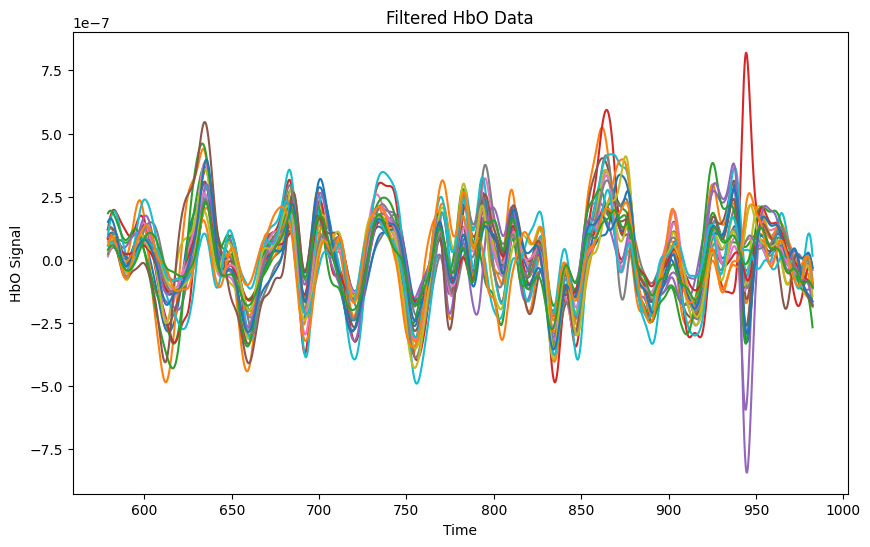

In [10]:
df = organize_data(BASE_DIR)

subject_1 = df.iloc[0]['data']

subject_1_data = load_task_data(subject_1)
subject_1_vf_task = subject_1_data['VF']

HbO = subject_1_vf_task['HbO']['data']

# Transpose HbO
HbO = HbO.T

time = HbO.iloc[:, 0]
channels = HbO.iloc[:, 2:]
marker = HbO.iloc[:, 1].astype('int32')

number_of_samples = time.shape[0]
total_duration = time.max() - time.min()
sampling_frequency = number_of_samples / total_duration

print(f"Sampling Frequency: {sampling_frequency}")

indices_1_3 = marker[marker.isin([1, 3])]
counts = indices_1_3.value_counts()

# Get the indices where the marker is 1 and 3
indices_1 = marker[marker == 1].index
indices_3 = marker[marker == 3].index
last_3_idx = indices_3[-1]

time_final_row = time.iloc[-1]

duration_last_3_to_end = time_final_row - time.loc[last_3_idx]
print(f"The time between the last '3' marker and the end of the recording is: {duration_last_3_to_end}")

print(f"indices_1: {indices_1}")
print(f"indices_3: {indices_3}")

# Find the second occurrence of '1' and the first occurrence of '3'
second_1_idx = indices_1[1]  # Second "1"
first_3_idx = indices_3[0]   # First "3"
second_3_idx = indices_3[1]  # Second "3"
third_3_idx = indices_3[2]   # Third "3"
fourth_3_idx = indices_3[3]   # Fourth "3"
print(time.shape)

# Get the corresponding times from the 'time' column
time_second_1 = time.loc[second_1_idx]
time_first_3 = time.loc[first_3_idx]
time_second_3 = time.loc[second_3_idx]
time_third_3 = time.loc[third_3_idx]
time_fourth_3 = time.loc[fourth_3_idx]

duration = time_first_3 - time_second_1

duration_first_3_second_3 = time_second_3 - time_first_3
duration_second_3_third_3 = time_third_3 - time_second_3
duration_third_3_fourth_3 = time_fourth_3 - time_third_3
duration_total = time_fourth_3 - time_first_3

# Display the result
print(f"The time between the second '1' and the first '3' marker is: {duration}")
print(f"The time between the first trigger and the second trigger is: {duration_first_3_second_3}")
print(f"The time between the second trigger and the third trigger is: {duration_second_3_third_3}")
print(f"The time between the third trigger and the fourth trigger is: {duration_third_3_fourth_3}")
print(f"The total time between the first trigger and the fourth trigger is: {duration_total}")

time_first_3 = time.loc[first_3_idx]
time_last_3 = time.loc[last_3_idx]

time_before_first_3 = time_first_3 - 60
time_after_last_3 = time_last_3 + 60

filtered_data = pd.DataFrame(HbO[(time >= time_before_first_3) & (time <= time_after_last_3)])
print(filtered_data.shape)

time_filtered = filtered_data.iloc[:, 0]
channels_filtered = filtered_data.iloc[:, 2:]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(time_filtered, channels_filtered)
plt.title("Filtered HbO Data")
plt.xlabel("Time")
plt.ylabel("HbO Signal")
plt.show()


## Check `fs` Sampling Rate

- Each subjects did following tasks: 
  - `1backWM` (1 Back Working Memory)
  - `VF` (Verbal Fluency)
  - `SS`
  - `GNG` (Go No Go)

In [222]:
# Assuming 'organize_data' and 'load_task_data' are functions to organize and load your data
df = organize_data(BASE_DIR)

# Calculate the sampling frequency for the 'VF' task
sampling_frequencies = calculate_sampling_frequency(df, 'VF')

Subject AA011 does not have a 'VF' task, skipping.
Subject LA053 does not have a 'VF' task, skipping.


In [223]:
# Create lists for the two frequency groups
group_7_8_Hz = []
group_10_1_Hz = []

# Counters for healthy and non-healthy subjects in each group
healthy_7_8_Hz = 0
non_healthy_7_8_Hz = 0
healthy_10_1_Hz = 0
non_healthy_10_1_Hz = 0

# Loop through each subject info and group based on the sampling frequency
for subject_info in sampling_frequencies:
    freq = subject_info['sampling_frequency']
    
    # Group subjects by frequency range around 7.8 Hz or 10.1 Hz
    if 7.8 <= freq < 7.9:
        group_7_8_Hz.append(subject_info)
        if subject_info['class'] == 'healthy':
            healthy_7_8_Hz += 1
        else:
            non_healthy_7_8_Hz += 1
    elif 10.1 <= freq < 10.2:
        group_10_1_Hz.append(subject_info)
        if subject_info['class'] == 'healthy':
            healthy_10_1_Hz += 1
        else:
            non_healthy_10_1_Hz += 1

# Print the results for 7.8 Hz group
print("Group 7.8 Hz:")
for subject in group_7_8_Hz:
    print(f"Subject {subject['subject']} ({subject['class']}): {subject['sampling_frequency']} Hz")
print(f"Total Healthy: {healthy_7_8_Hz}")
print(f"Total Non-Healthy: {non_healthy_7_8_Hz}")

# Print the results for 10.1 Hz group
print("\nGroup 10.1 Hz:")
for subject in group_10_1_Hz:
    print(f"Subject {subject['subject']} ({subject['class']}): {subject['sampling_frequency']} Hz")
print(f"Total Healthy: {healthy_10_1_Hz}")
print(f"Total Non-Healthy: {non_healthy_10_1_Hz}")

# Save the two frequency groups to separate files
save_group_to_txt('group_7_8_Hz.txt', group_7_8_Hz)
save_group_to_txt('group_10_1_Hz.txt', group_10_1_Hz)

Group 7.8 Hz:
Subject AA001 (non-healthy): 7.813452395465073 Hz
Subject AA002 (non-healthy): 7.8136495732784 Hz
Subject AA003 (non-healthy): 7.8135401411263485 Hz
Subject AA004 (non-healthy): 7.8133610713104815 Hz
Subject AA005 (non-healthy): 7.813683712121213 Hz
Subject AA006 (non-healthy): 7.813576992004412 Hz
Subject AA007 (non-healthy): 7.813687129615561 Hz
Subject AA008 (non-healthy): 7.813700445605408 Hz
Subject AH009 (healthy): 7.813597878021361 Hz
Subject AH010 (healthy): 7.813679423309179 Hz
Total Healthy: 2
Total Non-Healthy: 8

Group 10.1 Hz:
Subject EA012 (non-healthy): 10.173721682441686 Hz
Subject AA013 (non-healthy): 10.173715530466666 Hz
Subject AH014 (healthy): 10.173758480193321 Hz
Subject AH015 (healthy): 10.173729178453552 Hz
Subject EA016 (non-healthy): 10.173652318558178 Hz
Subject AH017 (healthy): 10.173581284007332 Hz
Subject AH018 (healthy): 10.17368888163548 Hz
Subject AH019 (healthy): 10.173658211584632 Hz
Subject AH020 (healthy): 10.173724643609921 Hz
Subjec

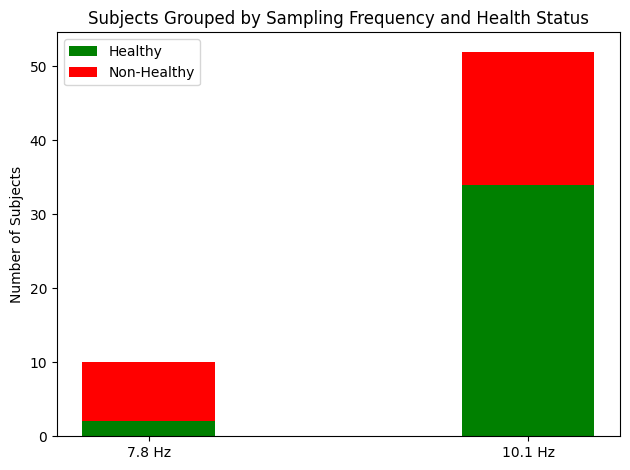

In [42]:
# Visualization: Bar Chart to Show Counts of Healthy vs Non-Healthy
labels = ['7.8 Hz', '10.1 Hz']
healthy_counts = [healthy_7_8_Hz, healthy_10_1_Hz]
non_healthy_counts = [non_healthy_7_8_Hz, non_healthy_10_1_Hz]

# Set up the bar chart
x = range(len(labels))
width = 0.35  # Width of the bars

fig, ax = plt.subplots()

# Plot bars for healthy and non-healthy
ax.bar(x, healthy_counts, width, label='Healthy', color='green')
ax.bar(x, non_healthy_counts, width, bottom=healthy_counts, label='Non-Healthy', color='red')

# Add labels, title, and legend
ax.set_ylabel('Number of Subjects')
ax.set_title('Subjects Grouped by Sampling Frequency and Health Status')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Check Class

In [12]:
df = organize_data(BASE_DIR)

classes = df['class']

# Calculate the number of healthy and non-healthy subjects
healthy_count = classes[classes == 'healthy'].count()
non_healthy_count = classes[classes == 'non-healthy'].count()

# Display the results
print(f"Number of Healthy Subjects: {healthy_count}")
print(f"Number of Non-Healthy Subjects: {non_healthy_count}")

print(df.columns)

Number of Healthy Subjects: 36
Number of Non-Healthy Subjects: 28
Index(['data', 'class'], dtype='object')


## 2nd Baseline ("1") Time Marker + 1st, 2nd, 3rd Task Trigger ("3") Time Marker

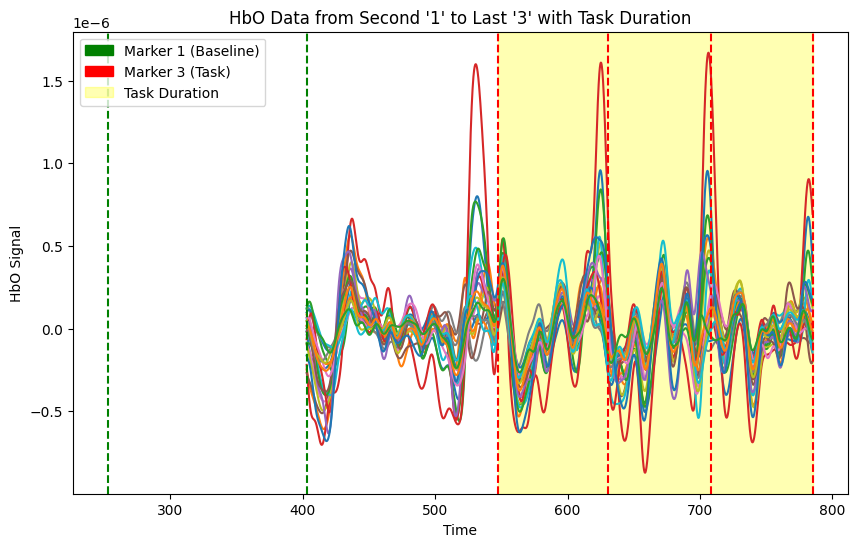

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df = organize_data(BASE_DIR)

subject = df.iloc[1]['data']

subject_data = load_task_data(subject)
subject_vf_task = subject_data['VF']

HbO = subject_vf_task['HbO']['data']
HbO = HbO.T

time = HbO.iloc[:, 0]
channels = HbO.iloc[:, 2:]
marker = HbO.iloc[:, 1].astype('int32')

# Get the indices where the marker is 1 and 3
indices_1 = marker[marker == 1].index
indices_3 = marker[marker == 3].index

# Find the first and last occurrence of '3'
first_3_idx = indices_3[0]   # First "3"
last_3_idx = indices_3[-1]   # Last "3"

# Get the corresponding times for the first and last '3'
time_first_3 = time.iloc[first_3_idx]
time_last_3 = time.iloc[last_3_idx]

# 1. Extract 30 seconds for the 2nd Baseline ("1")
time_baseline_start = time.iloc[indices_1[1]]  # Time of second "1" marker
time_baseline_end = time_first_3

baseline_data = HbO[(time >= time_baseline_start) & (time <= time_baseline_end)]

# 2. Extract the task data from the first "3" to the last "3"
task_data = HbO[(time >= time_first_3) & (time <= time_last_3)]

# 3. Combine the baseline and task data
final_data = pd.concat([baseline_data, task_data])

# Sort by the index (to maintain chronological order)
final_data_sorted = final_data.sort_index()

# Extract time and HbO signal from the final_data_sorted
time_data = final_data_sorted.iloc[:, 0]  # Assuming time is in the first column
hbo_signal = final_data_sorted.iloc[:, 2:]  # Assuming HbO signal is in the third column

# Plot the HbO signal
plt.figure(figsize=(10, 6))
plt.plot(time_data, hbo_signal, label='HbO Signal')

# Add vertical lines for marker 1 and marker 3
# Get the time points for markers '1' and '3' from the original time and marker data
time_markers_1 = time[marker == 1]
time_markers_3 = time[marker == 3]

# Plot vertical lines for marker 1
for t in time_markers_1:
    plt.axvline(x=t, color='green', linestyle='--', label='Marker 1')

# Plot vertical lines for marker 3
for t in time_markers_3:
    plt.axvline(x=t, color='red', linestyle='--', label='Marker 3')

# 4. Highlight the entire task duration from first "3" to last "3"
plt.axvspan(time_first_3, time_last_3, color='yellow', alpha=0.3, label='Task Duration')

# Set plot details
plt.title("HbO Data from Second '1' to Last '3' with Task Duration")
plt.xlabel("Time")
plt.ylabel("HbO Signal")

# Custom legend to represent the shaded task region
red_patch = mpatches.Patch(color='red', label='Marker 3 (Task)')
green_patch = mpatches.Patch(color='green', label='Marker 1 (Baseline)')
yellow_patch = mpatches.Patch(color='yellow', alpha=0.3, label='Task Duration')
plt.legend(handles=[green_patch, red_patch, yellow_patch])

# Show the plot
plt.show()


## Resampling 

- Some subject have `fs` around 7.8 Hz while other subject have `fs` around 10.1 Hz
- The goal is to resample subject with `fs` = `7.8 Hz` to `8 Hz` and `fs` = `10.1` Hz to `10 Hz`

- The time duration in seconds is given by:

  - $$\text{Time Duration (seconds)} = \frac{\text{Number of Samples}}{f_s}$$

- The frequency sampling (fs) is given by: 

  - $$f_s = \frac{\text{Number of Samples}}{\text{Time Duration (seconds)}}$$

## Windowing Data Based on the Time Marker

### 1. Extract Relevant Information (Baseline "1" 2nd + Task "3" 1st, 2nd, 3rd, and 4th)

- Calculate the duration of each task
- Pick the shortest duration as reference

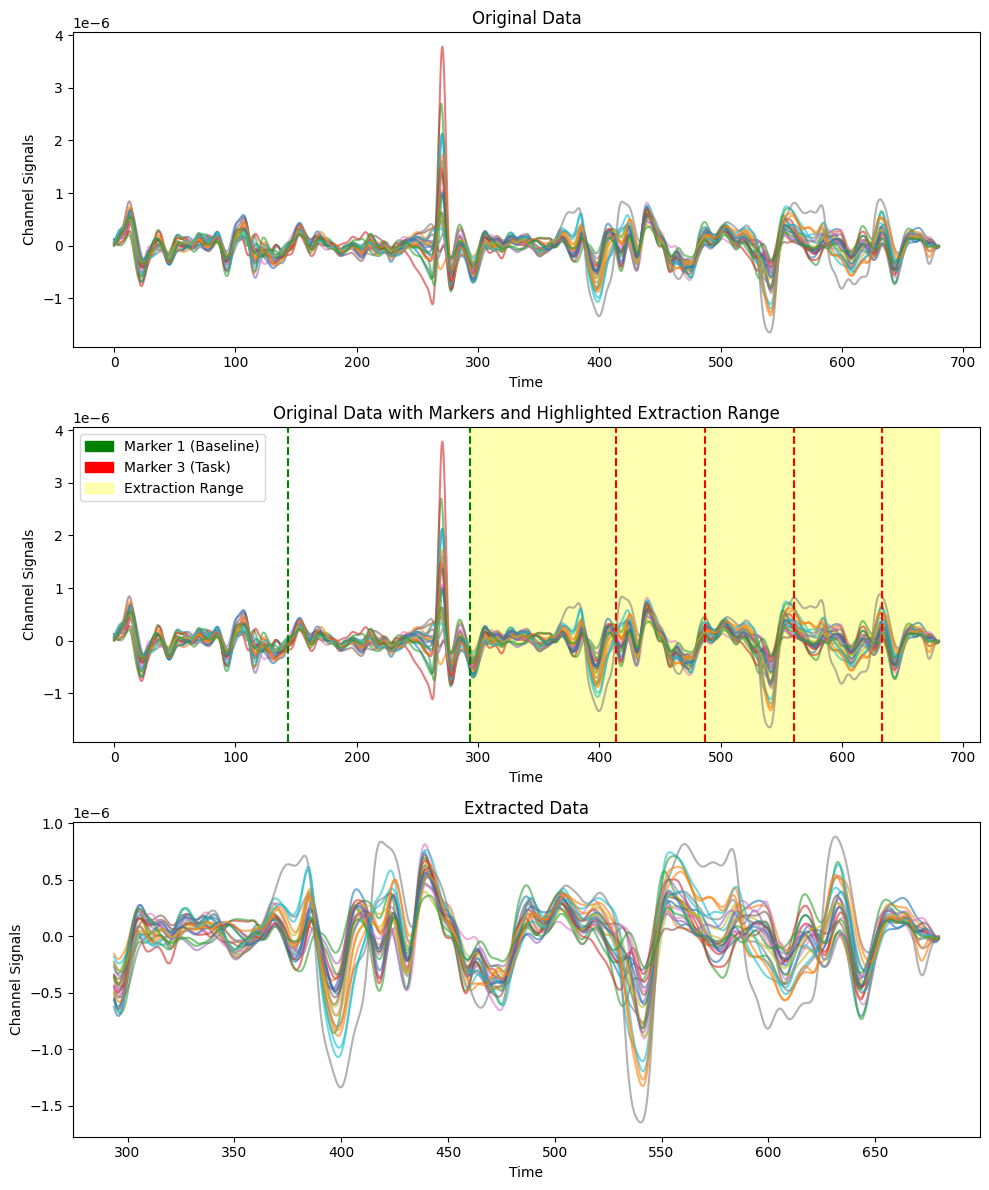

In [12]:
df = organize_data(BASE_DIR)

subject = df.iloc[11]['data']
subject_data = load_task_data(subject)
subject_vf_task = subject_data['GNG']

HbO = subject_vf_task['HbO']['data']

time = HbO.iloc[0, :]
channels = HbO.iloc[2:, :] # 23 Channels
# channels = HbO.iloc[2:3, :] # 2 Channels
marker = HbO.iloc[1, :].astype('int32')

indices_1_3 = marker[marker.isin([1, 3])]
counts = indices_1_3.value_counts()

indices_1 = marker[marker == 1].index
indices_3 = marker[marker == 3].index

first_3_idx = indices_3[0]
last_3_idx = indices_3[-1]
last_data_idx = channels.shape[1] - 1

time_baseline_start = time.iloc[indices_1[1]]
time_baseline_end = time.iloc[first_3_idx]

time_task_start = time.iloc[first_3_idx]
time_task_end = time.iloc[last_data_idx]

# Ensure the time mask is consistent for both data and time extraction
time_mask = (time >= time_baseline_start) & (time <= time_task_end)

baseline_data = channels.loc[:, (time >= time_baseline_start) & (time <= time_baseline_end)]
baseline_time = time[(time >= time_baseline_start) & (time <= time_baseline_end)]
task_data = channels.loc[:, (time >= time_task_start) & (time <= time_task_end)]

# Extract data and time using the same mask
extracted_data = channels.loc[:, time_mask]
extracted_time = time[time_mask]
extracted_time_marker = marker[time_mask]

# Convert extracted_time to a DataFrame and reshape it as a row
extracted_time_df = pd.DataFrame(extracted_time.values.reshape(1, -1))
extracted_time_marker = pd.DataFrame(extracted_time_marker.values.reshape(1, -1))
extracted_data_df = pd.DataFrame(extracted_data.values)

concatenated_data = pd.concat([extracted_time_df, extracted_time_marker ,extracted_data_df], axis=0, ignore_index=True)

# Save the extracted data to a CSV file
concatenated_data.to_csv('extracted_data.csv', index=False, header=False)

## Plot the extracted data
plot_fnirs_data(time, channels, marker, time_baseline_start, time_task_end, extracted_time, extracted_data)

### 2. Cutting Longer Task Duration to be Matched with the Shortest Task Duration

- Based on the shortest time duration, I use this reference to create a fixed-time window to cut the longer task.
  - Calculate the half window size based on the shortest task duration divided by time $$\text{half\_window\_size} = \frac{\frac{\text{shortest\_task\_duration}}{2}}{\text{time}[1] - \text{time}[0]}$$
    - `half_window_size`: This is the result of the calculation.
    - `shortest_task_duration`: This represents half the duration of the shortest task.
    - `time[1] - time[0]`: This represents the time step between consecutive time points, giving the number of samples per second.


239
3973
4451


239
4719
5197


239
5462
5940


239
6196
6674


(1912, 23)
(1912,)
Index([4212, 4958, 5701, 6435], dtype='int64')


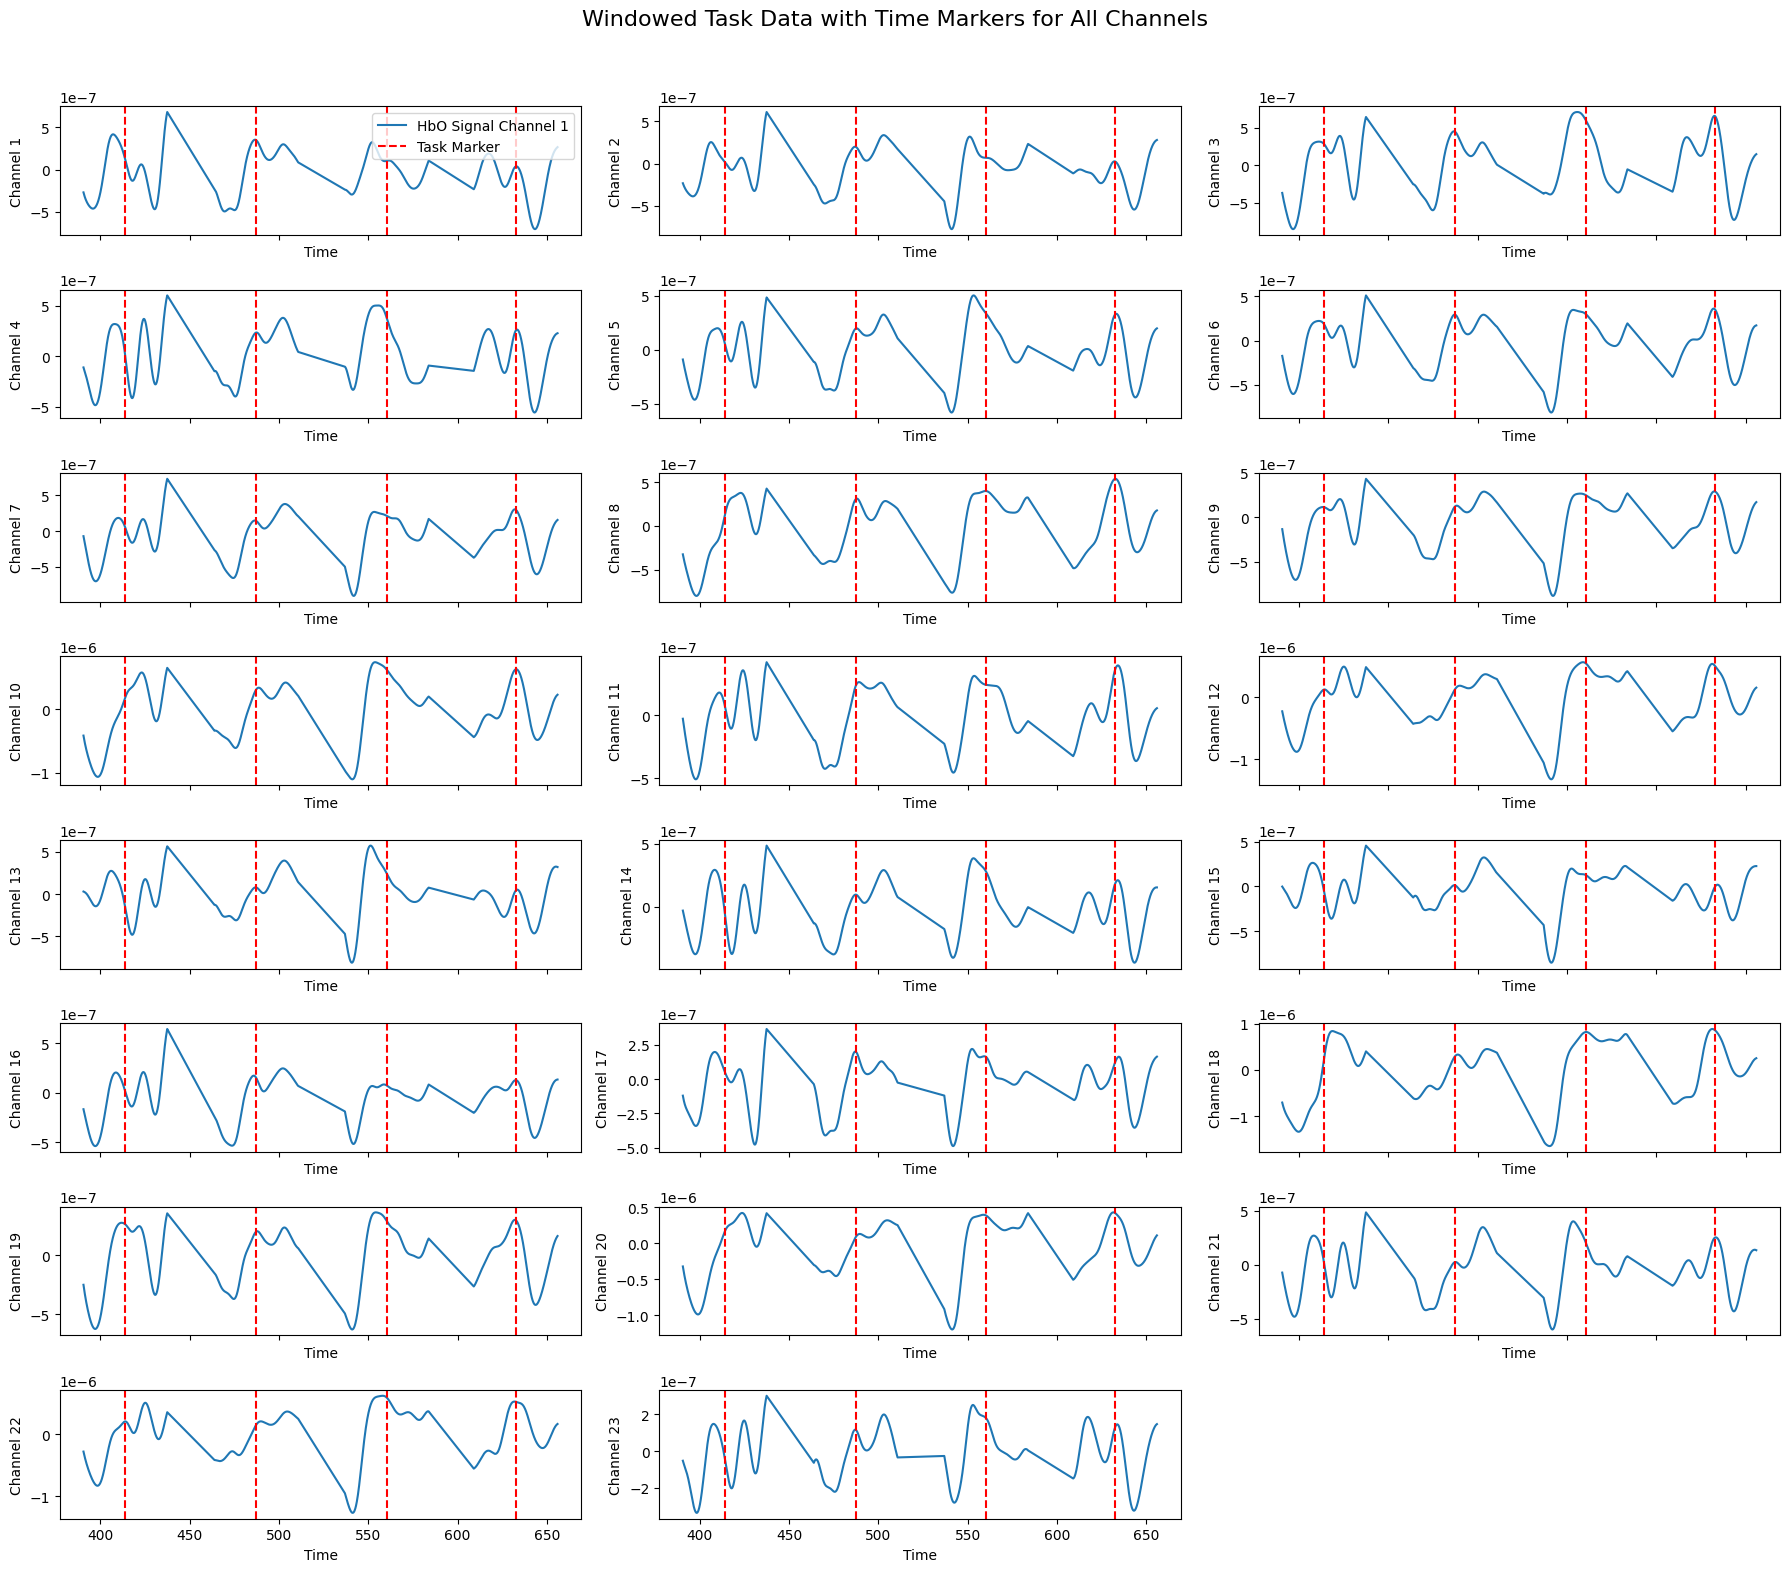

In [98]:
# Calculate duration of each task based on indices_3
task_durations = []
for i in range(len(indices_3) - 1):
    task_start = indices_3[i]
    next_task_start = indices_3[i + 1]
    task_duration = time.iloc[next_task_start] - time.iloc[task_start]
    task_durations.append(task_duration)

# For the last task, calculate the duration up to the end of the data
last_task_duration = time.iloc[-1] - time.iloc[indices_3[-1]]
task_durations.append(last_task_duration)

shortest_task_duration = min(task_durations)

# Step 3: Perform windowing on the longer tasks based on the shortest task
windowed_data_list = []
windowed_time_list = []

for i in range(len(indices_3)):
    task_start = indices_3[i]
    
    # Calculate the half window size in terms of index steps
    half_window_size = int((shortest_task_duration / 2) / (time.iloc[1] - time.iloc[0]))
    print(half_window_size)

    # Center the window around the start of the task
    window_start_idx = max(task_start - half_window_size, 0)
    print(window_start_idx)
    window_end_idx = min(task_start + half_window_size, len(time) - 1)
    print(window_end_idx)
    print("\n")

    # Extract the windowed time and data
    windowed_time = time.iloc[window_start_idx:window_end_idx]
    windowed_data = channels.iloc[:, window_start_idx:window_end_idx]

    windowed_data_list.append(windowed_data)
    windowed_time_list.append(windowed_time)

# Concatenate the windowed data and time for all tasks
final_windowed_data = pd.concat(windowed_data_list, axis=1)
final_windowed_time = pd.concat(windowed_time_list)

# Step 4: Check the duration of each windowed task
windowed_task_durations = []
for windowed_time in windowed_time_list:
    task_duration = windowed_time.iloc[-1] - windowed_time.iloc[0]
    windowed_task_durations.append(task_duration)

# # Print the duration of each windowed task
# for i, duration in enumerate(windowed_task_durations):
#     print(f"Task {i + 1} duration after windowing: {duration}")

# Now print the final shape of the windowed data and time
print(final_windowed_data.T.shape)
print(final_windowed_time.shape)

print(indices_3)

# Create subplots with 3 columns, adjusting the number of rows accordingly
n_channels = final_windowed_data.shape[0]
n_rows = (n_channels + 2) // 3  # This ensures we have enough rows for 3 columns

# Create the figure and subplots
fig, axs = plt.subplots(n_rows, 3, figsize=(18, 2 * n_rows), sharex=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Plot each channel in a separate subplot
for i in range(n_channels):
    # Plot the signal for the current channel
    axs[i].plot(final_windowed_time, final_windowed_data.T.iloc[:, i], label=f'HbO Signal Channel {i+1}')
    
    # Plot the task time markers as vertical lines
    for idx in indices_3:
        axs[i].axvline(x=time.iloc[idx], color='red', linestyle='--', label='Task Marker' if i == 0 and idx == indices_3[0] else "")
    
    # Add labels and title for each subplot
    axs[i].set_ylabel(f'Channel {i+1}')
    if i == 0:
        axs[i].legend(loc='upper right')

# Add shared x-axis label for all subplots
for ax in axs:
    ax.set_xlabel('Time')

# Remove empty subplots if there are any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add a main title
fig.suptitle("Windowed Task Data with Time Markers for All Channels", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


# New Dataset

### 1. Grouping the RAW Dataset into `7.8... Hz` and `10.1... Hz`

In [4]:
df = organize_data(BASE_DIR)

group_7_8_Hz_metadata = pd.read_csv(Path('../data/extracted/group_7_8_Hz.txt'), sep='\t', header=None, names=['subject', 'class', 'sampling'])
group_10_1_Hz_metadata = pd.read_csv(Path('../data/extracted/group_10_1_Hz.txt'), sep='\t', header=None, names=['subject', 'class', 'sampling'])

df_7_8_Hz = df[df.index.isin(group_7_8_Hz_metadata['subject'])]
df_10_1_Hz = df[df.index.isin(group_10_1_Hz_metadata['subject'])]

### 2. Extract the Relevant Information based on Time Marker in Dataset with `7.8... Hz` and `10.1... Hz`

In [5]:
def extract_relevant_information(df, data_type, task, save_to_csv=False, save_path=None):
    extracted_info_list = []

    def process_subject(index, row):
        subject = row['data']
        subject_data = load_task_data(subject)

        if task not in subject_data:
            print(f"Subject {index} does not have the task {task}, skipping.")
            return None

        subject_task = subject_data[task]
        HbO_or_HbR_or_HbT = subject_task[data_type]['data']
        filename = subject_task[data_type]['filename']

        time = HbO_or_HbR_or_HbT.iloc[0, :]
        channels = HbO_or_HbR_or_HbT.iloc[2:, :]
        marker = HbO_or_HbR_or_HbT.iloc[1, :].astype('int32')

        indices_1 = marker[marker == 1].index
        time_baseline_start = time.iloc[indices_1[1]]
        time_task_end = time.iloc[-1]

        time_mask = (time >= time_baseline_start) & (time <= time_task_end)
        extracted_data = channels.loc[:, time_mask]
        extracted_time = time[time_mask]
        extracted_time_marker = marker[time_mask]

        extracted_information = pd.concat([
            pd.DataFrame(extracted_time.values.reshape(1, -1)),
            pd.DataFrame(extracted_time_marker.values.reshape(1, -1)),
            pd.DataFrame(extracted_data.values)
        ], axis=0, ignore_index=True)

        if save_to_csv and save_path is not None:
            class_label = row['class']
            class_folder = 'healthy' if class_label == 'healthy' else 'non-healthy'
            subject_folder = os.path.join(save_path, class_folder, str(index), task)
            os.makedirs(subject_folder, exist_ok=True)
            file_path = os.path.join(subject_folder, f"{filename}.csv")
            extracted_information.to_csv(file_path, index=False, header=False)
            print(f"Saved {file_path}")

        return {'subject': index, 'extracted_information': extracted_information}

    results = df.apply(lambda row: process_subject(row.name, row), axis=1)
    extracted_info_list = [result for result in results if result is not None]

    return pd.DataFrame(extracted_info_list)

In [6]:
save_path_10_1_Hz = Path('../data/extracted/10_1_Hz')
save_path_7_8_Hz = Path('../data/extracted/7_8_Hz')

## Extract relevant information for the 'VF' task
extracted_info_10_1_Hz = extract_relevant_information(df_10_1_Hz, data_type='HbT', task='VF', save_to_csv=True, save_path=save_path_10_1_Hz)
# extracted_info_10_1_Hz = extract_relevant_information(df_10_1_Hz, data_type='HbT', task='1backWM', save_to_csv=True, save_path=save_path_10_1_Hz)
# extracted_info_10_1_Hz = extract_relevant_information(df_10_1_Hz, data_type='HbT', task='SS', save_to_csv=True, save_path=save_path_10_1_Hz)
# extracted_info_10_1_Hz = extract_relevant_information(df_10_1_Hz, data_type='HbT', task='GNG', save_to_csv=True, save_path=save_path_10_1_Hz)

# extracted_info_7_8_Hz = extract_relevant_information(df_7_8_Hz, data_type='HbT', task='VF', save_to_csv=True, save_path=save_path_7_8_Hz)
# extracted_info_7_8_Hz = extract_relevant_information(df_7_8_Hz, data_type='HbT', task='1backWM', save_to_csv=True, save_path=save_path_7_8_Hz)
# extracted_info_7_8_Hz = extract_relevant_information(df_7_8_Hz, data_type='HbT', task='SS', save_to_csv=True, save_path=save_path_7_8_Hz)
# extracted_info_7_8_Hz = extract_relevant_information(df_7_8_Hz, data_type='HbT', task='GNG', save_to_csv=True, save_path=save_path_7_8_Hz)

### 3. Windowing Process

- Step 1 🟰 Aggregate the `.csv` filepath of each task `VF`, `1backWm`, `SS`, and `GNG` for `HbO`
- Step 2 🟰 Read and apply function to calculate the shortest duration of each `.csv` file and return the shortest task duration of each task `VF`, `1backWm`, `SS`, and `GNG` also return the duration of the 2nd Baseline to the first task for `HbO`
- Step 3 🟰 Use the shortest duration from the baseline to the first task as a reference for trimming the rest of the data, ensuring uniformity across all datasets.
- Step 4 🟰 Assume each `VF`, `1backWM`, `SS`, and `GNG` is either `healthy` and `non-healthy` based on the class label found on the sub-folder 📁 name
- Step 5 🟰 Create a new dataset stored in the `windowing/10_1_Hz` 📁 ➡️ `healthy/non-healthy` 📁 ➡️ `subject` 📁 ➡️ `HbO/HbR/HbT.csv` 

**NOTE**: `HbO, HbR, and HbT` file for each task have the same shape, i.e., _same number of rows and columns_

- Step 6 🟰 Use another approach by setting a fix window length based on the shortest duration in each task `VF`, `1backWM`, `SS`, and `GNG`

#### Step 1: Aggregate the `.csv` filepath of each task `VF`, `1backWm`, `SS`, and `GNG` for `HbO`

In [22]:
# Step 1: Aggregate the `.csv` filepath of each task `VF`, `1backWm`, `SS`, and `GNG` for `HbO`
df_10_1_Hz_extracted = Path('../../data/extracted/7_8_Hz')

def aggregate_task_data(path_extracted_data, data_type='HbO'):
    """
    Aggregates the file paths of tasks (VF, 1backWM, SS, GNG) for the specified data type(s).

    Args:
        path_extracted_data (str or Path): Path to the directory containing extracted data.
        data_type (str): Type of data to filter for ('HbO', 'HbR', 'HbT', or 'all'). 
                         Defaults to 'HbO'. If 'all', all data types will be included.

    Returns:
        dict: A dictionary containing the aggregated file paths for each class and task.
    """
    path_extracted_data = Path(path_extracted_data)
    
    # Find unique class labels in the extracted group
    class_labels = [folder for folder in os.listdir(path_extracted_data) if os.path.isdir(path_extracted_data / folder)]

    # Create a dictionary to store the data for each class
    class_data = {}

    # Define the available data types
    available_data_types = ['HbO', 'HbR', 'HbT']
    
    # Determine which data types to collect based on input
    if data_type == 'all':
        data_types_to_collect = available_data_types
    else:
        data_types_to_collect = [data_type]

    # Load the data for each class
    for class_label in class_labels:
        class_folder = path_extracted_data / class_label

        subject_folders = [f for f in os.listdir(class_folder) if os.path.isdir(class_folder / f)]

        task_data = {}

        for subject_folder in subject_folders:
            subject_folder_path = class_folder / subject_folder
            task_folders = [f for f in os.listdir(subject_folder_path) if os.path.isdir(subject_folder_path / f)]

            for task_folder in task_folders:
                task_folder_path = subject_folder_path / task_folder
                task_files = os.listdir(task_folder_path)
                
                # Filter task files to return only files containing the specified data types
                for dt in data_types_to_collect:
                    data_files = [f for f in task_files if dt in f]
                    
                    for data_file in data_files:
                        file_path = task_folder_path / data_file

                        # Convert Path object to string before storing
                        if task_folder not in task_data:
                            task_data[task_folder] = [str(file_path)]  # Convert to string
                        else:
                            task_data[task_folder].append(str(file_path))  # Convert to string

        # Store the task data in the class_data dictionary
        class_data[class_label] = task_data

    return class_data


class_data_10_1_Hz = aggregate_task_data(df_10_1_Hz_extracted, data_type='HbO')

In [23]:
print(class_data_10_1_Hz)

{'healthy': {'1backWM': ['..\\..\\data\\extracted\\7_8_Hz\\healthy\\AH009\\1backWM\\2023-09-04_002_HbO.csv', '..\\..\\data\\extracted\\7_8_Hz\\healthy\\AH010\\1backWM\\2023-09-04_006_HbO.csv'], 'VF': ['..\\..\\data\\extracted\\7_8_Hz\\healthy\\AH009\\VF\\2023-09-04_001_HbO.csv', '..\\..\\data\\extracted\\7_8_Hz\\healthy\\AH010\\VF\\2023-09-04_005_HbO.csv']}, 'non-healthy': {'1backWM': ['..\\..\\data\\extracted\\7_8_Hz\\non-healthy\\AA001\\1backWM\\2023-06-19_003_HbO.csv', '..\\..\\data\\extracted\\7_8_Hz\\non-healthy\\AA002\\1backWM\\2023-06-20_002_HbO.csv', '..\\..\\data\\extracted\\7_8_Hz\\non-healthy\\AA003\\1backWM\\2023-06-21_002_HbO.csv', '..\\..\\data\\extracted\\7_8_Hz\\non-healthy\\AA004\\1backWM\\2023-07-05_002_HbO.csv', '..\\..\\data\\extracted\\7_8_Hz\\non-healthy\\AA005\\1backWM\\2023-08-01_002_HbO.csv', '..\\..\\data\\extracted\\7_8_Hz\\non-healthy\\AA006\\1backWM\\2023-08-09_002_HbO.csv', '..\\..\\data\\extracted\\7_8_Hz\\non-healthy\\AA007\\1backWM\\2023-08-10_002_HbO.c

#### Step 2: Read and apply function to calculate the shortest duration of each `.csv` file and return the shortest task duration of each task `VF`, `1backWm`, `SS`, and `GNG` also return the duration of the 2nd Baseline to the first task for `HbO`

In [24]:
# Step 2: Read and apply function to calculate the shortest duration of each `.csv` file and return the shortest task duration of each task `VF`, 
# `1backWm`, `SS`, and `GNG` also return the duration of the 2nd Baseline to the first task for `HbO`

non_healthy_10_1_Hz = class_data_10_1_Hz['non-healthy']
healthy_10_1_Hz = class_data_10_1_Hz['healthy']

# Apply the method to all files in the non-healthy of each task and return a dictionary contains of calculated shortest task duration of each files
non_healthy_10_1_Hz_all_task_shortest_durations = {
    task: [calculate_shortest_task_duration(file_path) for file_path in file_paths]
    for task, file_paths in non_healthy_10_1_Hz.items()
}

non_healthy_10_1_Hz_baseline_to_first_task_durations = {
    task: [calculate_baseline_to_first_task_duration(file_path) for file_path in file_paths]
    for task, file_paths in non_healthy_10_1_Hz.items()
}

# Apply the method to all files in the healthy of each task and return a dictionary contains of calculated shortest task duration of each files
healthy_10_1_Hz_all_task_shortest_durations = {
    task: [calculate_shortest_task_duration(file_path) for file_path in file_paths]
    for task, file_paths in healthy_10_1_Hz.items()
}

healthy_10_1_Hz_baseline_to_first_task_durations = {
    task: [calculate_baseline_to_first_task_duration(file_path) for file_path in file_paths]
    for task, file_paths in healthy_10_1_Hz.items()
}

In [42]:
# for task, durations_list in non_healthy_10_1_Hz_all_task_shortest_durations.items():
#     # Filter to show "GNG"
#     if task == 'GNG':
#         for shortest_durations, durations, task_total_duration, filepath, shape in durations_list:
#             print(f"  Shortest Duration: {shortest_durations}")
#             print(f"  Duration: {durations}")
#             print(f"  Total Duration: {task_total_duration}")
#             print(f"  Filepath: {filepath}")
#             print(f"  Shape: {shape} \n")

for task, durations_list in healthy_10_1_Hz_all_task_shortest_durations.items():
    # Filter to show "GNG"
    if task == 'GNG':
        for shortest_durations, durations, task_total_duration, filepath, shape in durations_list:
            print(f"  Shortest Duration: {shortest_durations}")
            print(f"  Duration: {durations}")
            print(f"  Total Duration: {task_total_duration}")
            print(f"  Filepath: {filepath}")
            print(f"  Shape: {shape} \n")

  Shortest Duration: 68.91110420227
  Duration: [81.69062399864197, 68.91110420227, 69.30431985855097, 379.846656084061]
  Total Duration: 599.7527041435239
  Filepath: 2023-12-05_004_HbO.csv
  Shape: (25, 7451) 

  Shortest Duration: 69.795840024948
  Duration: [70.18905591964699, 70.48396801948604, 69.795840024948, 97.910784006119]
  Total Duration: 308.37964797020004
  Filepath: 2023-12-05_006_HbO.csv
  Shape: (25, 4610) 

  Shortest Duration: 44.33510398864803
  Duration: [79.42963194847096, 69.59923195839002, 69.40262389182999, 44.33510398864803]
  Total Duration: 262.766591787339
  Filepath: 2023-12-12_004_HbO.csv
  Shape: (25, 3960) 

  Shortest Duration: 47.48083209991398
  Duration: [70.090751886367, 69.89414405822794, 70.87718391418503, 47.48083209991398]
  Total Duration: 258.34291195869395
  Filepath: 2023-12-12_008_HbO.csv
  Shape: (25, 3902) 

  Shortest Duration: 42.467328071595034
  Duration: [68.51788806915198, 69.10771179199298, 70.58227205276404, 42.467328071595034]


In [25]:
shortest_durations_baseline_to_task = find_shortest_duration(healthy_10_1_Hz_baseline_to_first_task_durations)
longest_durations_baseline_to_task = find_longest_duration(healthy_10_1_Hz_baseline_to_first_task_durations)

shortest_durations_task = find_shortest_duration_task(healthy_10_1_Hz_all_task_shortest_durations)
longest_durations_task = find_longest_duration_task(healthy_10_1_Hz_all_task_shortest_durations)

# Print the result
print("Shortest Durations Baseline to Task:")
for task, details in shortest_durations_baseline_to_task.items():
    print(f"Task: {task}, Duration: {details['duration']}, Filepath: {details['filepath']}, Shape: {details['shape']}")

print("\n")

print("Longest Durations Baseline to Task:")
for task, details in longest_durations_baseline_to_task.items():
    print(f"Task: {task}, Duration: {details['duration']}, Filepath: {details['filepath']}, Shape: {details['shape']}")

print("\n")
print("Shortest Durations Task to Task:")
for task, details in shortest_durations_task.items():
    print(f"Task: {task}, Duration: {details['shortest_duration']}, Task Durations: {details['task_durations']}, Total Durations: {details['total_duration']}, Filepath: {details['filepath']}, Shape: {details['shape']}")

print("\n")
print("Longest Durations Task to Task:")
for task, details in longest_durations_task.items():
    print(f"Task: {task}, Duration: {details['longest_duration']}, Task Durations: {details['task_durations']}, Total Durations: {details['total_duration']}, Filepath: {details['filepath']}, Shape: {details['shape']}")

Shortest Durations Baseline to Task:
Task: 1backWM, Duration: 135.80800000000005, Filepath: 2023-09-04_006_HbO.csv, Shape: (25, 4255)
Task: VF, Duration: 136.06400000000002, Filepath: 2023-09-04_005_HbO.csv, Shape: (25, 3473)


Longest Durations Baseline to Task:
Task: 1backWM, Duration: 148.60799999999995, Filepath: 2023-09-04_002_HbO.csv, Shape: (25, 4472)
Task: VF, Duration: 193.92000000000002, Filepath: 2023-09-04_001_HbO.csv, Shape: (25, 4077)


Shortest Durations Task to Task:
Task: 1backWM, Duration: 99.71199999999999, Task Durations: [119.55200000000002, 99.71199999999999, 102.65600000000006, 101.75999999999999], Total Durations: 423.68000000000006, Filepath: 2023-09-04_002_HbO.csv, Shape: (25, 4472)
Task: VF, Duration: 76.15999999999997, Task Durations: [88.06399999999996, 77.82400000000007, 76.15999999999997, 85.75999999999999], Total Durations: 327.808, Filepath: 2023-09-04_001_HbO.csv, Shape: (25, 4077)


Longest Durations Task to Task:
Task: 1backWM, Duration: 100.86400000

In [32]:
shortest_durations_baseline_to_task = find_shortest_duration(non_healthy_10_1_Hz_baseline_to_first_task_durations)
longest_durations_baseline_to_task = find_longest_duration(non_healthy_10_1_Hz_baseline_to_first_task_durations)

shortest_durations_task = find_shortest_duration_task(non_healthy_10_1_Hz_all_task_shortest_durations)
longest_durations_task = find_longest_duration_task(non_healthy_10_1_Hz_all_task_shortest_durations)

# Print the result
print("Shortest Durations Baseline to Task:")
for task, details in shortest_durations_baseline_to_task.items():
    print(f"Task: {task}, Duration: {details['duration']}, Filepath: {details['filepath']}, Shape: {details['shape']}")

print("\n")

print("Longest Durations Baseline to Task:")
for task, details in longest_durations_baseline_to_task.items():
    print(f"Task: {task}, Duration: {details['duration']}, Filepath: {details['filepath']}, Shape: {details['shape']}")

print("\n")
print("Shortest Durations Task to Task:")
for task, details in shortest_durations_task.items():
    print(f"Task: {task}, Duration: {details['shortest_duration']}, Task Durations: {details['task_durations']}, Total Durations: {details['total_duration']}, Filepath: {details['filepath']}, Shape: {details['shape']}")

print("\n")
print("Longest Durations Task to Task:")
for task, details in longest_durations_task.items():
    print(f"Task: {task}, Duration: {details['longest_duration']}, Task Durations: {details['task_durations']}, Total Durations: {details['total_duration']}, Filepath: {details['filepath']}, Shape: {details['shape']}")

Shortest Durations Baseline to Task:
Task: 1backWM, Duration: 123.076607942581, Filepath: 2024-01-15_002_HbO.csv, Shape: (25, 6556)
Task: GNG, Duration: 120.32409596443199, Filepath: 2023-11-28_005_HbO.csv, Shape: (25, 3928)
Task: SS, Duration: 125.63251209258999, Filepath: 2024-01-08_008_HbO.csv, Shape: (25, 5130)
Task: VF, Duration: 127.79520010948096, Filepath: 2024-01-19_008_HbO.csv, Shape: (25, 5303)


Longest Durations Baseline to Task:
Task: 1backWM, Duration: 160.530431985856, Filepath: 2024-01-19_001_HbO.csv, Shape: (25, 6816)
Task: GNG, Duration: 133.98835182189896, Filepath: 2023-12-07_001_HbO.csv, Shape: (25, 4424)
Task: SS, Duration: 139.88659191131597, Filepath: 2024-05-08_003_HbO.csv, Shape: (25, 5498)
Task: VF, Duration: 154.92710399627703, Filepath: 2023-12-07_005_HbO.csv, Shape: (25, 5493)


Shortest Durations Task to Task:
Task: 1backWM, Duration: 99.0904321670539, Task Durations: [127.10707211494503, 127.008767843246, 126.22233605384804, 99.0904321670539], Total Dur

#### Step 3: Use the shortest duration from the baseline to the first task as a reference for trimming the rest of the data, ensuring uniformity across all datasets.

Shortest duration for file 1: (143.8187520504, '2023-11-29_001_HbO.csv', (25, 7939)) seconds
Shortest duration for file 2: (145.19500780105602, '2023-12-27_007_HbO.csv', (25, 6509)) seconds
df_1_shape: (25, 7939)
df_2_shape: (25, 6509)
indices_1_df_1: Index([0], dtype='int64')
indices_1_df_2: Index([0], dtype='int64')
indices_3_df_1: 1463
indices_3_df_2: 1477
Samples to trim: 1430
New df_1_shape after trimming: (25, 6509)
df_2_shape: (25, 6509)


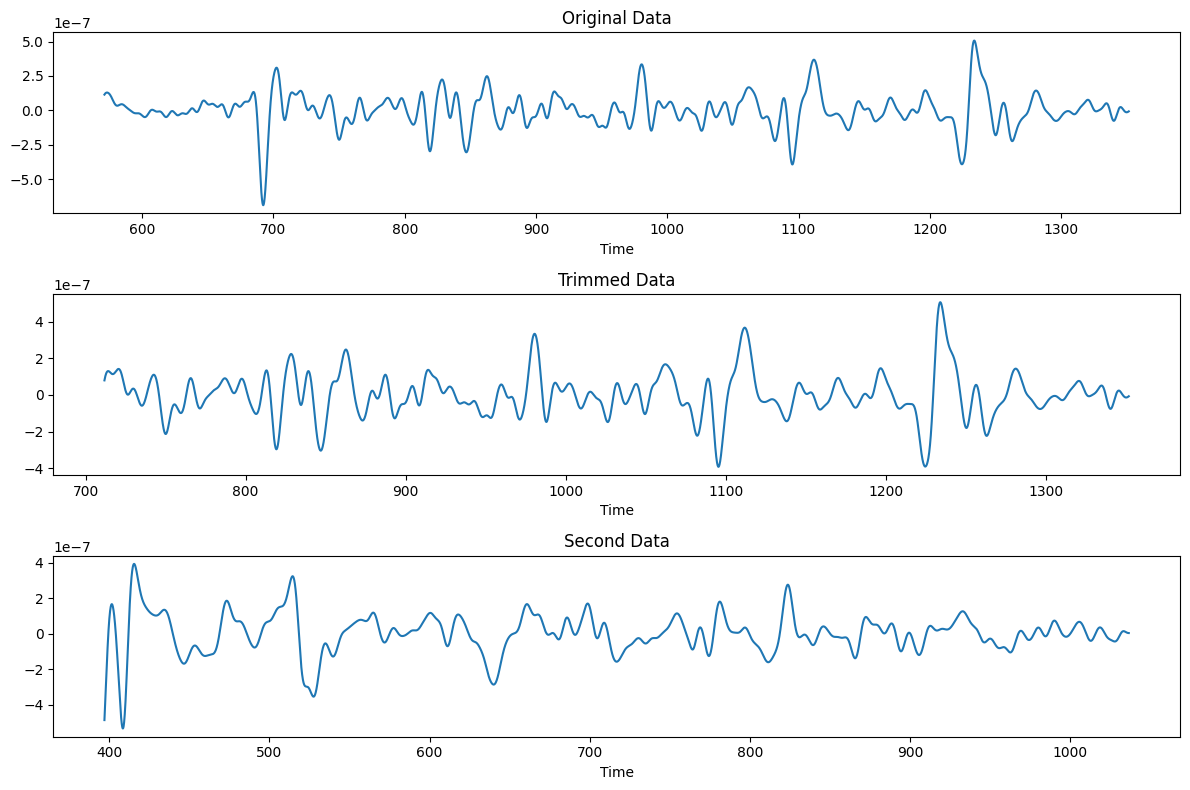

In [234]:
# Step 3: Use the shortest duration from the baseline to the first task as a reference for trimming the rest of the data, ensuring uniformity 
# across all datasets.

# Try with two files
file_path_1 = non_healthy_10_1_Hz['1backWM'][0]
file_path_2 = non_healthy_10_1_Hz['1backWM'][1]

# Calculate baseline to the first task duration for both files
shortest_duration_1 = calculate_baseline_to_first_task_duration(file_path_1)
print(f"Shortest duration for file 1: {shortest_duration_1} seconds")
shortest_duration_2 = calculate_baseline_to_first_task_duration(file_path_2)
print(f"Shortest duration for file 2: {shortest_duration_2} seconds")

# Get the shortest baseline duration
shortest_duration = min(shortest_duration_1, shortest_duration_2)

# Load the data
df_1 = pd.read_csv(file_path_1, header=None)
df_2 = pd.read_csv(file_path_2, header=None)

print(f"df_1_shape: {df_1.shape}")
print(f"df_2_shape: {df_2.shape}")

# Extract the time, markers, and channel data
time_1 = df_1.iloc[0, :]
time_2 = df_2.iloc[0, :]

markers_1_df_1 = df_1.iloc[1, :].astype('int32')
markers_1_df_2 = df_2.iloc[1, :].astype('int32')

channels_1 = df_1.iloc[2, :]
channels_2 = df_2.iloc[2, :]

# Find indices of the baseline (marker "1") and the first task (marker "3")
indices_1_df_1 = markers_1_df_1[markers_1_df_1 == 1].index
indices_1_df_2 = markers_1_df_2[markers_1_df_2 == 1].index

indices_3_df_1 = markers_1_df_1[markers_1_df_1 == 3].index
indices_3_df_2 = markers_1_df_2[markers_1_df_2 == 3].index

print(f"indices_1_df_1: {indices_1_df_1}")
print(f"indices_1_df_2: {indices_1_df_2}")

print(f"indices_3_df_1: {indices_3_df_1[0]}")
print(f"indices_3_df_2: {indices_3_df_2[0]}")

samples_to_trim = df_1.shape[1] - df_2.shape[1]
print(f"Samples to trim: {samples_to_trim}")

if samples_to_trim > 0:  # Ensure we're trimming only if necessary
    # Only trim up to the number of baseline samples
    indices_to_trim = min(samples_to_trim, indices_3_df_1[0])
    trimmed_df_1 = df_1.drop(columns=range(indices_to_trim), axis=1)
else:
    trimmed_df_1 = df_1  # No trimming needed if shapes are already equal

print(f"New df_1_shape after trimming: {trimmed_df_1.shape}")
print(f"df_2_shape: {df_2.shape}")

# Plot the trimmed data in subplot
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
ax[0].plot(time_1, channels_1.T)
ax[0].set_title("Original Data")
ax[0].set_xlabel("Time")

ax[1].plot(trimmed_df_1.iloc[0, :], trimmed_df_1.iloc[2, :].T)
ax[1].set_title("Trimmed Data")
ax[1].set_xlabel("Time")

ax[2].plot(time_2, channels_2.T)
ax[2].set_title("Second Data")
ax[2].set_xlabel("Time")

plt.tight_layout()
plt.show()

#### Step 6: Use another approach by setting a fix window length duration in each task `VF`, `1backWM`, `SS`, and `GNG`

..\data\extracted\10_1_Hz\non-healthy\EA061\GNG\2024-02-06_003_HbO.csv
df_1_shape: (25, 3924)
indices_3_df_1: Index([1292, 2026, 2753, 3466], dtype='int64')
Fixed-length time window (number of columns to keep): 2535
New df_1 shape after truncation: (25, 2535)


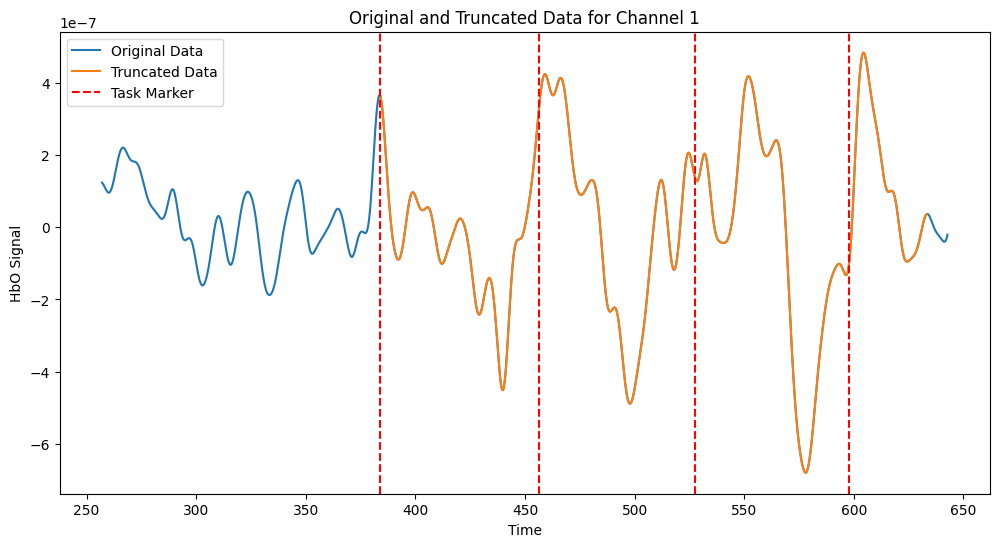

In [16]:
# Step 6: Use another approach by setting a fixed window length based on the shortest duration in each task `VF`, `1backWM`, 
# `SS`, and `GNG`

# Start with `VF` task
# Shortest duration from baseline to 1st task = Task: VF, Duration: 127.79520010948096, Filepath: 2024-01-19_008_HbO.csv, Shape: (25, 5303)
# Shortest duration from task to task = Task: VF, Duration: 71.663615942001, Filepath: 2024-01-08_005_HbO.csv, Shape: (25, 5257)

# Set a fixed-length window of baseline to 1st task duration using 120s for the `VF` task
non_healthy_10_1_Hz = class_data_10_1_Hz['non-healthy']
healthy_10_1_Hz = class_data_10_1_Hz['healthy']
file_path_1 = non_healthy_10_1_Hz['GNG'][8]

df_1 = pd.read_csv(file_path_1, header=None)
print(f"df_1_shape: {df_1.shape}")

time_1 = df_1.iloc[0, :]  # Time series
markers_1_df_1 = df_1.iloc[1, :].astype('int32')  # Markers
channels_1_df_1 = df_1.iloc[2:, :]  # Channels data

# Get the indices for the start of the baseline (marker 1) and the start of the task (marker 3)
indices_1_df_1 = markers_1_df_1[markers_1_df_1 == 1].index
indices_3_df_1 = markers_1_df_1[markers_1_df_1 == 3].index
print(f"indices_3_df_1: {indices_3_df_1}")

# Set a sampling rate of 10.1 Hz and the fixed-length time to be 251s
sampling_rate = 10.1
fixed_length_time = 251
fixed_length_time_window = int(fixed_length_time * sampling_rate)
print(f"Fixed-length time window (number of columns to keep): {fixed_length_time_window}")

# Find the starting point (first marker 3) for truncation
start_index = indices_3_df_1[0]  # First occurrence of marker 3
end_index = start_index + fixed_length_time_window  # Calculate end based on the window length

# Ensure end_index does not exceed the number of columns in the dataframe
end_index = min(end_index, df_1.shape[1])

# Truncate the data from start_index to end_index
truncated_df_1 = df_1.iloc[:, start_index:end_index]
print(f"New df_1 shape after truncation: {truncated_df_1.shape}")

# Plot the original and truncated data for Channel 1
plt.figure(figsize=(12, 6))
plt.plot(time_1, channels_1_df_1.iloc[0, :], label='Original Data')
plt.plot(time_1[start_index:end_index], truncated_df_1.iloc[2, :], label='Truncated Data')

# Draw the marker of vertical red lines from the original data
for idx in indices_3_df_1:
    plt.axvline(x=time_1[idx], color='red', linestyle='--', label='Task Marker' if idx == indices_3_df_1[0] else "")

plt.title("Original and Truncated Data for Channel 1")
plt.xlabel("Time")
plt.ylabel("HbO Signal")
plt.legend()
plt.show()

In [49]:
def truncate_and_save_task_data(data, task_type, fs, fixed_length_time, save_base_dir):
    """
    Truncate data for a specific task type and save it to a CSV file in the specified path.

    Args:
        data (dict): Dictionary containing the data paths for each class (healthy/non-healthy).
        task_type (str): Type of task (e.g., 'GNG', 'VF', '1backWM', 'SS').
        fs (float): Sampling rate (Hz).
        fixed_length_time (int): Fixed length of time in seconds for truncation.
        save_base_dir (str or Path): Base directory where the truncated data will be saved.

    Returns:
        None. Saves the truncated data as a .csv file.
    """

    # Define classes and iterate over them
    classes = ['non-healthy', 'healthy']
    
    # Convert the save_base_dir to a Path object
    save_base_dir = Path(save_base_dir)

    # Iterate over both classes: 'healthy' and 'non-healthy'
    for class_type in classes:
        class_data = data.get(class_type, {})
        
        # If the class data is available for the specific task type
        if task_type in class_data:
            task_files = class_data[task_type]
            
            for file_path in task_files:
                # Load the data
                df = pd.read_csv(file_path, header=None)
                
                # Extract time, markers, and channels
                markers = df.iloc[1, :].astype('int32')  # Markers

                # Get indices for the start of the task (marker 3)
                task_indices = markers[markers == 3].index
                
                if not task_indices.empty:
                    # Set the fixed-length window in terms of columns
                    fixed_length_time_window = int(fixed_length_time * fs)
                    
                    # Find the starting point (first occurrence of marker 3)
                    start_index = task_indices[0]
                    end_index = start_index + fixed_length_time_window
                    
                    # Ensure end_index does not exceed the number of columns in the dataframe
                    end_index = min(end_index, df.shape[1])

                    # Truncate the data from start_index to end_index
                    truncated_df = df.iloc[:, start_index:end_index]
                    
                    # Extract the relative path to use for saving
                    relative_path = Path(file_path).relative_to('..', 'data', 'extracted', '10_1_Hz')
                    
                    # Construct the new folder path based on the save_base_dir
                    new_folder = save_base_dir / relative_path.parent
                    
                    # Ensure the directory exists, if not create it
                    os.makedirs(new_folder, exist_ok=True)
                    
                    # Create the new file path for saving
                    new_file_path = new_folder / relative_path.name

                    # Save the truncated dataframe as a .csv file
                    truncated_df.to_csv(new_file_path, header=False, index=False)
                    
                    print(f"Saved truncated data to {new_file_path}")

truncate_and_save_task_data(class_data_10_1_Hz, 'GNG', fs=10.1, fixed_length_time=240, save_base_dir=Path('../data/truncated/10_1_Hz'))

Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\AA013\GNG\2023-11-29_002_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\AA041\GNG\2023-12-27_005_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\AA056\GNG\2024-01-17_001_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\AA064\GNG\2024-05-08_001_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\EA012\GNG\2023-11-28_005_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\EA016\GNG\2023-12-07_001_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\EA055\GNG\2024-01-15_005_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\EA060\GNG\2024-02-02_007_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\EA061\GNG\2024-02-06_003_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\non-healthy\EA062\GNG\2024-02-21_004_HbO.csv
Saved truncated data to ..\data\truncated\10_1_Hz\

In [72]:
df_10_1_Hz_truncated = Path('../data/truncated/10_1_Hz')
class_data_10_1_Hz = aggregate_task_data(df_10_1_Hz_truncated, data_type='all')
print(class_data_10_1_Hz)

{'healthy': {'GNG': ['..\\data\\truncated\\10_1_Hz\\healthy\\AH014\\GNG\\2023-12-05_004_HbO.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH014\\GNG\\2023-12-05_004_HbR.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH014\\GNG\\2023-12-05_004_HbT.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH015\\GNG\\2023-12-05_006_HbO.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH015\\GNG\\2023-12-05_006_HbR.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH015\\GNG\\2023-12-05_006_HbT.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH017\\GNG\\2023-12-12_004_HbO.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH017\\GNG\\2023-12-12_004_HbR.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH017\\GNG\\2023-12-12_004_HbT.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH018\\GNG\\2023-12-12_008_HbO.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH018\\GNG\\2023-12-12_008_HbR.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH018\\GNG\\2023-12-12_008_HbT.csv', '..\\data\\truncated\\10_1_Hz\\healthy\\AH019\\GNG\\202